# pyslammer demo: batch simulations
This notebook shows an example use case of pyslammer for running batch simulations.

## Setup

Assumes pyslammer is installed in the current python environment. 
*Documentation on installation pending*

First, import pyslammer using:

```python
import pyslammer as slam
```

Additional Python libriaries, such as `matplotlib` may also be useful.

In [1]:
# If running in Jupyterlite with Pyodide, install the additional packages
%pip install pyslammer
%pip install ipywidgets
%pip install numpy
%pip install sympy
%pip install scipy
%pip install matplotlib
%pip install ipympl
%matplotlib widget

In [2]:
# If running on a local machine with the full pyslammer repository, just add the parent directory to the path
# import sys
# sys.path.append('..')


In [3]:
import pyslammer as slam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Input

Running an sliding block analysis with pySLAMMER requires at least two sets of input: 1) Slope parameters, and 2) a ground motion.

## Slope Parameters

For any analysis type, a yield acceleration, $k_y$, is needed. 
*IN DEVELOPMENT: If coupled or decoupled analysis is performed, additional inputs are required. For any analysis type, at least one value of $k_y$ is needed, but $k_y$ can also be a function of displacement.*


## Ground motion

TODO: expand

## Single simulation
Run a single rigid sliding block analysis and plot the output.
A Northridge earthquake recording and a yield acceleration of 0.2 g are used

Displacement: 18.5898 cm


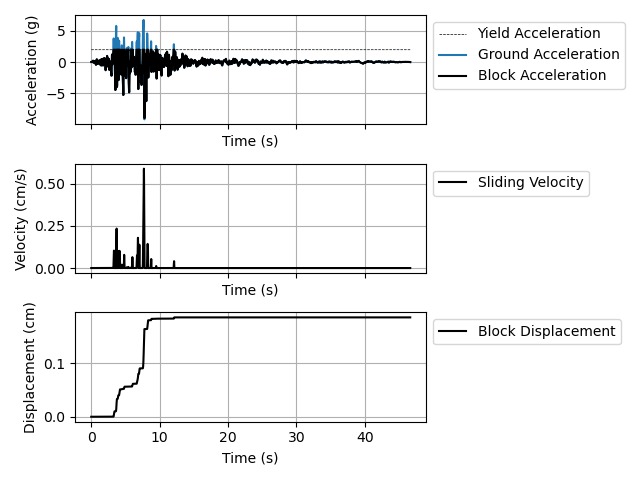

In [4]:
# single simulation
ky = 0.2

tHist = slam.csv_time_hist('sample_ground_motions/Northridge_VSP-360.csv')
# tHist[1] /= 9.81 (if g is needed)
result = slam.SlidingBlockAnalysis(tHist, ky)
plt.close('all')
fig, axs = slam.sliding_block_plot(result)
plt.show()

## Batch simulation
Eventually, this will be a more powerful demo with several parameter options. 
Currently, there's only one recorded ground motion pre-loaded and one analysis type (rigid). 
But soon, we'll have a small suite of recorded ground motions whose results can be easily compared.

In [5]:
kys = np.linspace(0.01,0.7,100)
tHist = slam.csv_time_hist('sample_ground_motions/Northridge_VSP-360.csv')


output = {}

# TODO: suppress printing displacement by default
for ky in kys:
    result = slam.SlidingBlockAnalysis(tHist, ky)
    output[ky] = {"d_max": result.max_sliding_disp, "time":result.time, "disp": result.sliding_disp}

# convert the output to a pandas dataframe
df = pd.DataFrame.from_dict(output,orient='index')
df = df.reset_index()
df = df.rename(columns={df.columns[0]: "ky"})


Displacement: 370.1392 cm
Displacement: 266.7552 cm
Displacement: 214.6565 cm
Displacement: 180.8934 cm
Displacement: 152.2120 cm
Displacement: 131.1952 cm
Displacement: 113.1064 cm
Displacement: 96.8832 cm
Displacement: 83.3901 cm
Displacement: 73.4433 cm
Displacement: 65.6760 cm
Displacement: 59.3652 cm
Displacement: 53.8064 cm
Displacement: 49.0782 cm
Displacement: 44.9970 cm
Displacement: 41.4809 cm
Displacement: 38.8021 cm
Displacement: 36.4061 cm
Displacement: 34.1670 cm
Displacement: 32.0520 cm
Displacement: 30.0698 cm
Displacement: 28.1899 cm
Displacement: 26.3950 cm
Displacement: 24.7413 cm
Displacement: 23.1502 cm
Displacement: 21.6665 cm
Displacement: 20.2520 cm
Displacement: 18.9215 cm
Displacement: 17.6577 cm
Displacement: 16.4688 cm
Displacement: 15.3546 cm
Displacement: 14.4169 cm
Displacement: 13.5476 cm
Displacement: 12.7218 cm
Displacement: 11.9249 cm
Displacement: 11.2036 cm
Displacement: 10.5186 cm
Displacement: 9.8860 cm
Displacement: 9.2751 cm
Displacement: 8.7057

One way way can plot these results is to look at the maximum displacement for each analysis by its yield acceleration:

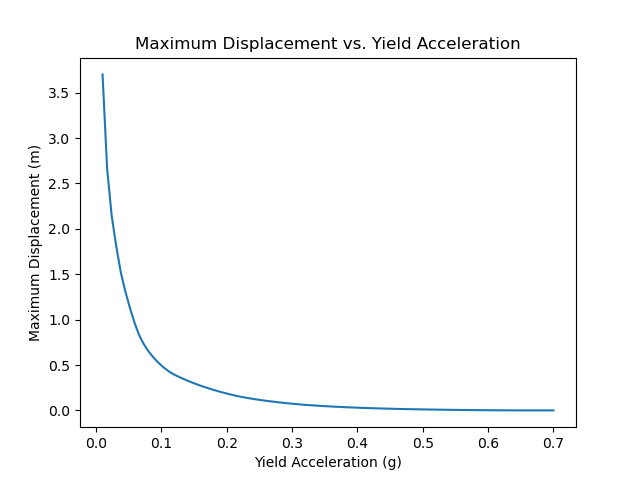

In [6]:
fig, ax = plt.subplots()
ax.plot(df["ky"],df["d_max"])
ax.set_xlabel('Yield Acceleration (g)')
ax.set_ylabel('Maximum Displacement (m)')
ax.set_title('Maximum Displacement vs. Yield Acceleration')
plt.show()

Because pyslammer returns the full displacement time history for each analysis, we can also plot the time histories for every analysis and color them by ky:

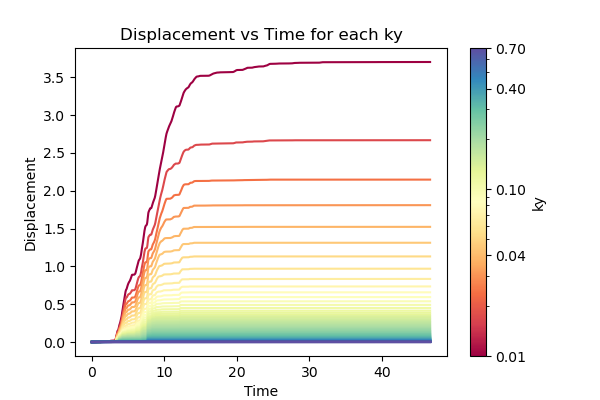

In [7]:

import matplotlib.cm as cm
from matplotlib.colors import LogNorm

# Create a figure and axes
fig, ax = plt.subplots(figsize=(6, 4))

# Create a color map
cmap = plt.colormaps['Spectral']#cm.get_cmap('viridis')
norm = LogNorm(df['ky'].min(), df['ky'].max())

# Iterate over the rows of the DataFrame
for index, row in df.iterrows():
    color = cmap(norm(row['ky']))
    ax.plot(row['time'], row['disp'], color=color)
    
# ax.set_yscale('log')
# ax.set_ylim([0.001,10])

# Add a color bar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
# Add a color bar
cbar = fig.colorbar(sm, ax=ax, label='ky')

# Set the colorbar ticks and labels
ticks = [0.01, 0.04, 0.1, 0.4, 0.7]#np.linspace(df['ky'].min(), df['ky'].max(), num=5)  # Adjust num for more or fewer ticks
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{tick:.2f}' for tick in ticks])  # Adjust the format as needed

ax.set_xlabel('Time')
ax.set_ylabel('Displacement')
ax.set_title('Displacement vs Time for each ky')
plt.show()